# Classifying Document

In [ ]:
import warnings
from tqdm import tqdm
import numpy as np
import pandas as pd
from itertools import accumulate
from IPython.display import Markdown as md
import plotly.graph_objs as go
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torchtext.datasets import AG_NEWS
from torch.utils.data.dataset import random_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset

def warn(*args, **kwargs):
  pass

warnings.warn = warn
warnings.filterwarnings('ignore')

## Helper functions

In [6]:
def plot(COST, ACC):
  fig, ax1 = plt.subplots()
  color = 'tab:red'
  ax1.plot(COST, color=color)
  ax1.set_xlabel('epoch', color=color)
  ax1.set_ylabel('total loss', color=color)
  ax1.tick_params(axis='y', color=color)

  ax2 = ax1.twinx()
  color = 'tab:blue'
  ax2.set_ylabel('accuracy', color=color)
  ax2.plot(ACC, color=color)
  ax2.tick_params(axis='y', color=color)
  fig.tight_layout()

  plt.show()

## Import bank dataset

In [13]:
train_iter = iter(AG_NEWS(split='train'))

y, text = next((train_iter))
print(f'Text: {text}')

ag_news_label = {1: 'World', 2: 'Sports', 3: 'Business', 4: 'Sci/Tec'}
print(f'Label: {y}, {ag_news_label[y]}')

num_class = len(set([label for (label, text) in train_iter]))
print(num_class)

Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
Label: 3, Business
4


## Dataset

You can convert the dataset into map-style datasets and then perform a random split to create separate training and validation datasets. The training dataset will contain 95% of the samples, while the validation dataset will contain the remaining 5%. These datasets can be used for training and evaluating a machine learning model for text classification on the AG_NEWS dataset.


In [21]:
train_iter, test_iter = AG_NEWS()

train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

num_train = int(len(train_dataset) * 0.95)

# Randomly split the training dataset into training and validation datasets
# The training dataset will contain 95% of the samples, and validation the remaining 5%.
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

If a GPU is available, it assigns the device variable to "cuda". If a GPU is not available, it assigns the device variable to "cpu" (which means the code will run on the CPU instead).

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Tokenize and build the vocabulary

In [15]:
train_iter = AG_NEWS(split='train')

tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
  for _, text in data_iter:
    yield tokenizer(text.lower())

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

print(f"Vocabulary size: {len(vocab)}")
print(f"Sample tokens: {list(vocab.get_stoi().keys())[:10]}")

Vocabulary size: 95811
Sample tokens: ['zyprexa', 'zwiki', 'zurab', 'zuhua', 'zubrin', 'zovko', 'zotinca', 'zos', 'zoology', 'zoner']


In [16]:
vocab(["age", "hello"])

[2120, 12544]

## Data Loader

In [30]:
# Get the token indices from the input text
def text_pipeline(x):
  return vocab(tokenizer(x))

# Ensure that the labels start at zero.
def label_pipeline(x):
  return int(x) - 1

def collate_batch(batch):
  label_list, text_list, offsets = [], [], [0]
  for _label, _text in batch:
    label_list.append(label_pipeline(_label))
    processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
    text_list.append(processed_text)
    offsets.append(processed_text.size(0))
  label_list = torch.tensor(label_list, dtype=torch.int64)
  offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
  text_list = torch.cat(text_list)
  return label_list.to(device), text_list.to(device), offsets.to(device)

BATCH_SIZE = 64

train_dataloader = DataLoader(
  split_train_,
  batch_size=BATCH_SIZE,
  shuffle=True,
  collate_fn=collate_batch
)

valid_dataloader = DataLoader(
  split_valid_,
  batch_size=BATCH_SIZE,
  shuffle=True,
  collate_fn=collate_batch
)

test_dataloader = DataLoader(
  test_dataset,
  batch_size=BATCH_SIZE,
  shuffle=True,
  collate_fn=collate_batch
)

In [29]:
label, text, offsets = next(iter(valid_dataloader))
label, text, offsets

(tensor([0, 1, 3, 1, 3, 2, 2, 3, 0, 3, 1, 1, 0, 1, 0, 3, 2, 3, 1, 2, 1, 0, 3, 2,
         0, 2, 0, 0, 2, 3, 0, 1, 2, 2, 3, 1, 3, 3, 2, 2, 1, 0, 2, 0, 2, 2, 1, 2,
         1, 0, 2, 2, 0, 0, 1, 2, 2, 1, 1, 3, 1, 3, 3, 2]),
 tensor([79699,   720,    46,  ...,  2711,   880,     1]),
 tensor([   0,   67,  123,  160,  201,  239,  283,  326,  351,  397,  445,  484,
          525,  556,  594,  648,  705,  743,  773,  838,  889,  983, 1042, 1067,
         1133, 1183, 1220, 1256, 1297, 1340, 1388, 1432, 1480, 1522, 1568, 1602,
         1640, 1683, 1715, 1768, 1804, 1858, 1899, 1942, 1980, 2022, 2059, 2098,
         2144, 2191, 2234, 2274, 2306, 2331, 2392, 2445, 2495, 2566, 2613, 2674,
         2716, 2756, 2802, 2863]))

## Neural Network

In [34]:
class TextClassificationModel(nn.Module):
  def __init__(self, vocab_size, embed_dim, num_class):
    super(TextClassificationModel, self).__init__()
    self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
    self.fc = nn.Linear(embed_dim, num_class)
    self.init_weights()

  def init_weights(self):
    initrange = 0.5
    self.embedding.weight.data.uniform_(-initrange, initrange)
    self.fc.weight.data.uniform_(-initrange, initrange)
    self.fc.bias.data.zero_()

  def forward(self, text, offsets):
    embedded = self.embedding(text, offsets)
    return self.fc(embedded)

emsize = 64
vocab_size = len(vocab)

model = TextClassificationModel(vocab_size, emsize, num_class).to(device)
model

TextClassificationModel(
  (embedding): EmbeddingBag(95811, 64, mode='mean')
  (fc): Linear(in_features=64, out_features=4, bias=True)
)

In [35]:
def predict(text, text_pipeline):
  with torch.no_grad():
    text = torch.tensor(text_pipeline(text))
    output = model(text, torch.tensor([0]))
    return ag_news_label[output.argmax(1).item() + 1]

predict("I like sports", text_pipeline)

'Sci/Tec'

In [36]:
def evaluate(dataloader):
  model.eval()
  total_acc, total_count = 0, 0
  with torch.no_grad():
    for idx, (label, text, offsets) in enumerate(dataloader):
      predicted_label = model(text, offsets)
      total_acc += (predicted_label.argmax(1) == label).sum().item()
      total_count += label.size(0)
  
  return total_acc / total_count

evaluate(test_dataloader)

0.22723684210526315

## Train the model

Set the learning rate (LR) to 0.1, which determines the step size at which the optimizer updates the model's parameters during training. The CrossEntropyLoss criterion is used to calculate the loss between the model's predicted outputs and the ground truth labels. This loss function is commonly employed for multi-class classification tasks.

The chosen optimizer is Stochastic Gradient Descent (SGD), which optimizes the model's parameters based on the computed gradients with respect to the loss function. The SGD optimizer uses the specified learning rate to control the size of the weight updates.

Additionally, a learning rate scheduler is defined using StepLR. This scheduler adjusts the learning rate during training, reducing it by a factor (gamma) of 0.1 after every epoch (step) to improve convergence and fine-tune the model's performance. These components together form the essential setup for training a neural network using the specified learning rate, loss criterion, optimizer, and learning rate scheduler.


In [39]:
LR = 0.1
EPOCHS = 10
cum_loss_list = []
acc_epoch = []
acc_old = 0

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

for epoch in tqdm(range(1, EPOCHS + 1)):
  model.train()
  cum_loss=0
  for idx, (label, text, offsets) in enumerate(train_dataloader):
    optimizer.zero_grad()
    predicted_label = model(text, offsets)
    loss = criterion(predicted_label, label)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
    optimizer.step()
    cum_loss += loss.item()

  cum_loss_list.append(cum_loss)
  accu_val = evaluate(valid_dataloader)
  acc_epoch.append(accu_val)

  if accu_val > acc_old:
    acc_old = accu_val
    torch.save(model.state_dict(), 'classifier_document_model.pth')
    


100%|██████████| 10/10 [01:40<00:00, 10.09s/it]


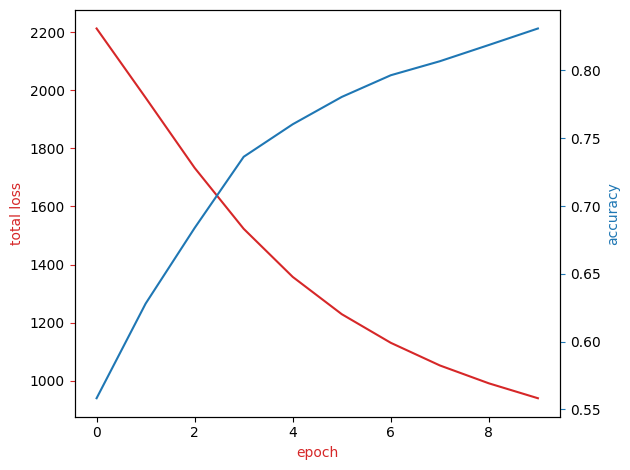

In [40]:
plot(cum_loss_list, acc_epoch)

In [41]:
evaluate(test_dataloader)

0.8210526315789474


This code snippet provides a summary for generating a 3D t-SNE visualization of embeddings using Plotly. It demonstrates how words that are similar to each other are positioned closer together.

In [ ]:
import plotly.io as pio
pio.renderers.default = "browser"

# Get the first batch from the validation data
batch = next(iter(valid_dataloader))

# Extract the text and offsets from the batch
label, text, offsets = batch

# Send the data to the device (GPU if available)
text = text.to(device)
offsets = offsets.to(device)

# Get the embeddings bag output for the batch
embedded = model.embedding(text, offsets)

# Convert the embeddings tensor to a numpy array
embeddings_numpy = embedded.detach().cpu().numpy()

# Perform t-SNE on the embeddings to reduce their dimensionality to 3D.
X_embedded_3d = TSNE(n_components=3).fit_transform(embeddings_numpy)

# Create a 3D scatter plot using Plotly
trace = go.Scatter3d(
    x=X_embedded_3d[:, 0],
    y=X_embedded_3d[:, 1],
    z=X_embedded_3d[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=label.numpy(),  # Use label information for color
        colorscale='Viridis',  # Choose a colorscale
        opacity=0.8
    )
)

layout = go.Layout(title="3D t-SNE Visualization of Embeddings",
                   scene=dict(xaxis_title='Dimension 1',
                              yaxis_title='Dimension 2',
                              zaxis_title='Dimension 3'))

fig = go.Figure(data=[trace], layout=layout)
fig.show()

In [48]:
article="""Canada navigated a stiff test against the Republic of Ireland on a rain soaked evening in Perth, coming from behind to claim a vital 2-1 victory at the Women’s World Cup.
Katie McCabe opened the scoring with an incredible Olimpico goal – scoring straight from a corner kick – as her corner flew straight over the despairing Canada goalkeeper Kailen Sheridan at Perth Rectangular Stadium in Australia.
Just when Ireland thought it had safely navigated itself to half time with a lead, Megan Connolly failed to get a clean connection on a clearance with the resulting contact squirming into her own net to level the score.
Minutes into the second half, Adriana Leon completed the turnaround for the Olympic champion, slotting home from the edge of the area to seal the three points."""

result = predict(article, text_pipeline)

markdown_content = f'''
<div style="background-color: black; padding: 10px;">
    <p>{article}</p>
    <strong>The category of the news article: {result}</strong>
</div>
'''

md(markdown_content)


<div style="background-color: black; padding: 10px;">
    <p>Canada navigated a stiff test against the Republic of Ireland on a rain soaked evening in Perth, coming from behind to claim a vital 2-1 victory at the Women’s World Cup.
Katie McCabe opened the scoring with an incredible Olimpico goal – scoring straight from a corner kick – as her corner flew straight over the despairing Canada goalkeeper Kailen Sheridan at Perth Rectangular Stadium in Australia.
Just when Ireland thought it had safely navigated itself to half time with a lead, Megan Connolly failed to get a clean connection on a clearance with the resulting contact squirming into her own net to level the score.
Minutes into the second half, Adriana Leon completed the turnaround for the Olympic champion, slotting home from the edge of the area to seal the three points.</p>
    <strong>The category of the news article: Sports</strong>
</div>


## Exercise 1

Load the pre-trained model (path = 'my_model.pth').

In [49]:
model.load_state_dict(torch.load('classifier_document_model.pth'))
model.eval()

TextClassificationModel(
  (embedding): EmbeddingBag(95811, 64, mode='mean')
  (fc): Linear(in_features=64, out_features=4, bias=True)
)

## Exercise 2

Define the list of new articles for classification

In [50]:
new_articles = [
    "International talks have made significant headway with the signing of a climate accord that commits countries to reduce emissions by 40% over the next two decades. World leaders expressed optimism at the conclusion of the summit.",
    "In a stunning upset, the underdog team won the national title, beating the favorites in a match that featured an incredible comeback and a last-minute goal that sealed their victory in front of a record crowd.",
    "Market analysts are optimistic as the tech startup's stock prices soared after the announcement of their latest product, which promises to revolutionize how we interact with smart devices.",
    "A recent study published in a leading scientific journal suggests that a new drug has shown promise in the treatment of Alzheimer's disease, outperforming current leading medications in early clinical trials.",
    "Diplomatic relations have taken a positive turn with the recent peace talks that aim to end decades of conflict. The ceasefire agreement has been welcomed by the international community.",
    "Economic indicators show a sharp rebound in manufacturing, with the automobile industry leading the charge. Analysts predict this surge will result in significant job creation over the next year.",
    "Researchers at the university's astrophysics department have discovered a potentially habitable exoplanet. The planet, which lies in a nearby star system, has conditions that could support liquid water and, possibly, life.",
    "The sports world is in shock as a legendary player announces their retirement. Over an illustrious 20-year career, the athlete has amassed numerous records and is regarded as one of the greatest to ever play the game.",
    "A multinational corporation has announced a major investment in renewable energy. The initiative includes the construction of new wind farms and solar panels that will power hundreds of thousands of homes.",
    "Climate scientists warn that the melting of the polar ice caps has been accelerating at an alarming rate, raising sea levels and threatening coastal cities worldwide with increased flooding risks."
]

## Exercise 3

Classify each article and display the results.

In [51]:
for i, article in enumerate(new_articles, start=1):
  prediction = predict(article, text_pipeline)
  print(f"Article {i} is classified as: {prediction}\n")

Article 1 is classified as: World

Article 2 is classified as: Sports

Article 3 is classified as: Business

Article 4 is classified as: Sci/Tec

Article 5 is classified as: World

Article 6 is classified as: Business

Article 7 is classified as: Sci/Tec

Article 8 is classified as: Sports

Article 9 is classified as: Sci/Tec

Article 10 is classified as: Sci/Tec

